This notebook demonstrates using SciPy to solve ODEs and Matplotlib for plotting

# Geodesics in Schwarzschild spacetime

The Schwarzschild spacetime describes an isolated spherically symmetric black hole. The (timelike) geodesic equations give the motion of a test mass around the black hole. In this notebook we give the equations, place them into first-order form, numerically integrate them and then plot the resulting orbit.

In this notebook we use geometrized units such that $G = c = 1$. The Schwarzschild black hole has mass $M$, and the Schwarzschild coordinates are $(t,r,\theta, \phi)$.

## Equations of motion 

Let the coordinates of the test body be denoted by $x^\mu_p(\tau) = \{t_p(\tau), r_p(\tau), \theta_p(\tau),\phi_p(\tau)\}$ where $\tau$ is the propertime (propertime is the time as mearsured by a clock movine along with the test body$. Using the Euler-Lagrange equations one can derive the equations of motion a test body in orbit about the black hole. These are given by the ODEs:

$$\begin{align}
\frac{dt}{d\tau} &= E^2(1-2M/r)^{-1}\\
\left(\frac{dr}{d\tau}\right)^2 &= E^2 - \left(1- \frac{2M}{r}\right)\left(1 + \frac{L^2}{r^2}\right)\\
\frac{d\phi}{d\tau} & = \frac{L}{r^2}
\end{align}$$

where $E$ and $L$ are the energy and angular momentum as measured at infinity.

Note due to spherical symmetry, without loss of generality we can set $\theta=\pi/2$ and $\theta$ does not evolve over the orbit.

## Manipulating the radial equation

The radial equation above is written in terms of first-order derivaties but it is not especially useful for numerical integration. That is because to use it you have to take a square root, which brings with it a $\pm$. The plus represents the outgoing motion from periastron to apastron, and the minus the ingoing motion. Switching between these two is difficult numerically.

A nice solution is to take a derviative of the whole radial equation w.r.t. $\tau$. This results in a second-order differenential equation which removes the troublesome $r'(\tau)$ term. The result of this operation is:

$$\frac{d^2r}{d\tau^2} = \frac{L^2(r-3M)}{r^4} - \frac{M}{r^2}$$

In order to numerically integrate this equation we now need to write this in first-order form. 
To do this we introduce $r_1 = dr/d\tau$, then the above equation can be written as two coupled first-order equations:

$$\begin{align}
   \frac{dr}{d\tau}   &= r_1 \\
   \frac{dr_1}{d\tau} &= \frac{L^2(r-3M)}{r^4} - \frac{M}{r^2}
\end{align}$$

## The systems of equations and initial conditions

In order to plot the orbital trajectory we only need the $r(\tau)$ an $\phi(\tau)$ solutions. This makes our set of ODEs:

$$\begin{align}
   \frac{dr}{d\tau}   &= r_1 \\
   \frac{dr_1}{d\tau} &= \frac{L^2(r-3M)}{r^4} - \frac{M}{r^2} \\
   \frac{d\phi}{d\tau} & = \frac{L}{r^2}
\end{align}$$

In order to solve these equations we need to specify the initial conditions at $\tau = \tau_0 $. Without loss of generality we will take $\tau_0 = 0$. We can define $r_0 \equiv r_0$ and $\phi(0) \equiv \phi_0$. Again, w.l.o.g we can take $\phi_0 = 0$.

What about $r_1(0) = dr/d\tau(0) \equiv u^r_0$. For this we can use the original version of the radial equation. Thus we have

$$ u^r_0 = \pm\sqrt{E^2 - \left(1- \frac{2M}{r}\right)\left(1 + \frac{L^2}{r^2}\right)}$$

# The energy and angular-momentum

We will now restrict out attention to bound orbits which have a minimum and maximum radius which we denote by $r_\min/r_\max$, respectively. We can further define two geometric quantities, the semi-latus rectum, $p$, and the orbital eccentricity, $e$. This are given by

$$ p \equiv \frac{2r_\max r_\min}{M(r_\max + r_\min)},\qquad e \equiv \frac{r_\max - r_\min}{r_\max + r_\min}$$

Inverting these equations we get

$$ r_\max = \frac{p}{1-e},\qquad r_\min = \frac{p}{1+e}$$

By looking at the effective potential, the energy and angular momentum can be written in terms of $(p,e)$. This gives

$$ E = \sqrt{\frac{(p-2-2e)(p-2+2e)}{p(p-3-e^2)}}, \qquad L = \sqrt{\frac{p^2 M^2}{p-3-e^2}}$$

In order to represent a stable bound orbit we must have $p > 6+2e$ and $0\le e<1$.

# Writing the code

We now want to write a code to compute the orbital trajectory. To do this we need to write a function that given $p$ and $e$:

1) computes $(E,L)$  
2) computes $u^r_0$  
3) integrates the ODEs  
4) plots the result  

In order to plot the results we define the cartesian coordinates via:

$$ x(\tau) = r(\tau) \cos[\phi(\tau)], \qquad y(\tau) = r(\tau) \sin[\phi(\tau)]$$

Next we load the libraries we will need and write the function that computes the geodesic and plots its spatial trajectory. Hereafter we will set $M=1$.

In [7]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# For the code below to work you need SciPy > 1.4 for the args argument in solve_ivp to work 
# See the release notes at https://scipy.github.io/devdocs/release.1.4.0.html
# If the below command returns a value less than 1.2 please update SciPy
import scipy
scipy.__version__

'1.4.1'

In [2]:
# Define the geodesic equations
def geodesicEqs(tau, y, L):
    r   = y[0]
    r1  = y[1]  
    
    dr  = r1
    dr1 = L**2*(r - 3)/r**4 - 1/r**2
    
    dphi = L/r**2
    
    
    return [dr, dr1, dphi]

In [3]:
def plotGeodesic(p, e, tau_max):
    
    # Compute the energy and angular momentum
    E = np.sqrt((p-2-2*e)*(p-2+2*e)/(p*(p-3-e**2)))
    L = np.sqrt(p**2/(p-3-e**2))
    
    # The initial conditions
    # Pick an r0 value between rmin and rmax
    r0 = p
    phi0 = 0
    
    # Calculate the initial value of the radial four-velocity
    ur0 = - np.sqrt(E**2 - (1-2/r0)*(L**2/r0**2 + 1) )
    
    # solve the geodesics with solve_ivp from SciPy
    sol = solve_ivp(geodesicEqs, [0, tau_max], [r0, ur0, 0], args = [L], t_eval = np.arange(0, tau_max, 1))
        
    rVals = sol.y[0]
    phiVals = sol.y[2]

    xVals = rVals*np.cos(phiVals)
    yVals = rVals*np.sin(phiVals)
    
    # Set the figure size
    plt.figure(figsize = (15,15))

    # Ensure the entire trajectory will be visible
    rmax = p/(1-e)

    plt.xlim(-rmax-1, rmax+1)
    plt.ylim(-rmax-1, rmax+1)
    
    # Draw a black disk for the black hole. The Schwarzschild radius is r_s = 2M.
    circle1 = plt.Circle((0, 0), 2, color='k')
    plt.gcf().gca().add_artist(circle1)
    
    # Plot the trajectory
    plt.plot(xVals, yVals)
    

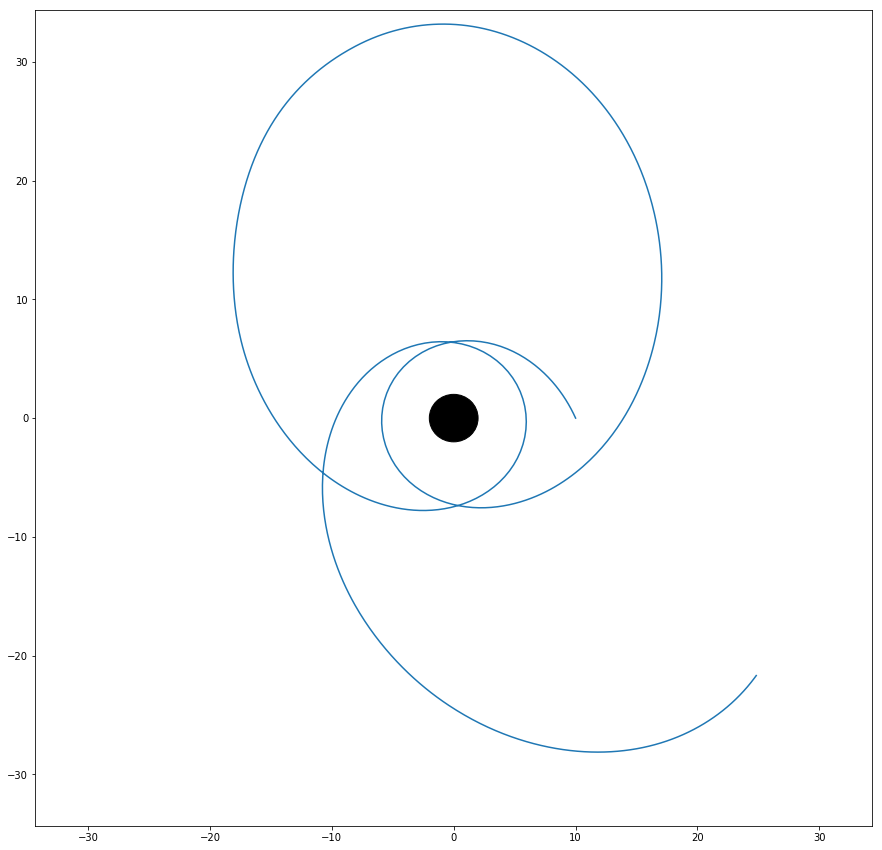

In [4]:
plotGeodesic(10,0.7,1000)